In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import tqdm as notebook_tqdm
import datasets
from datasets import load_dataset
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torch.nn as nn
from transformers import LayoutLMv3Processor
from transformers import AutoModel
import evaluate
from tqdm.auto import tqdm

## Step 1 - Getting Open Source Data

In [2]:
dataset = load_dataset("nielsr/funsd-layoutlmv3")

Found cached dataset funsd-layoutlmv3 (C:/Users/15148/.cache/huggingface/datasets/nielsr___funsd-layoutlmv3/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:

labels = dataset["train"].features["ner_tags"].feature.names
id2label = {v: k for v, k in enumerate(labels)}

In [4]:
## Visualizing the bounding boxes

def plot_visualization(sample : dict):

    from PIL import ImageDraw, ImageFont

    img = sample["image"]
    bbox = sample["bboxes"]
    ner_tags = sample["ner_tags"]
    
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    
    for box, predicted_label in zip(bbox, ner_tags):

        ## The bounding box has been rescaled to the range of [0, 1000] considering an image is [1000, 1000]
        box[0] = int(img.size[0] * box[0] / 1000)
        box[1] = int(img.size[1] * box[1] / 1000)
        box[2] = int(img.size[0] * box[2] / 1000)
        box[3] = int(img.size[1] * box[3] / 1000)
        
        draw.rectangle(box, outline = "violet")
        draw.text(
            (box[0] + 10, box[1] - 10),
            text=labels[predicted_label],
            fill="green",
            font=font,
        )
        
    return img

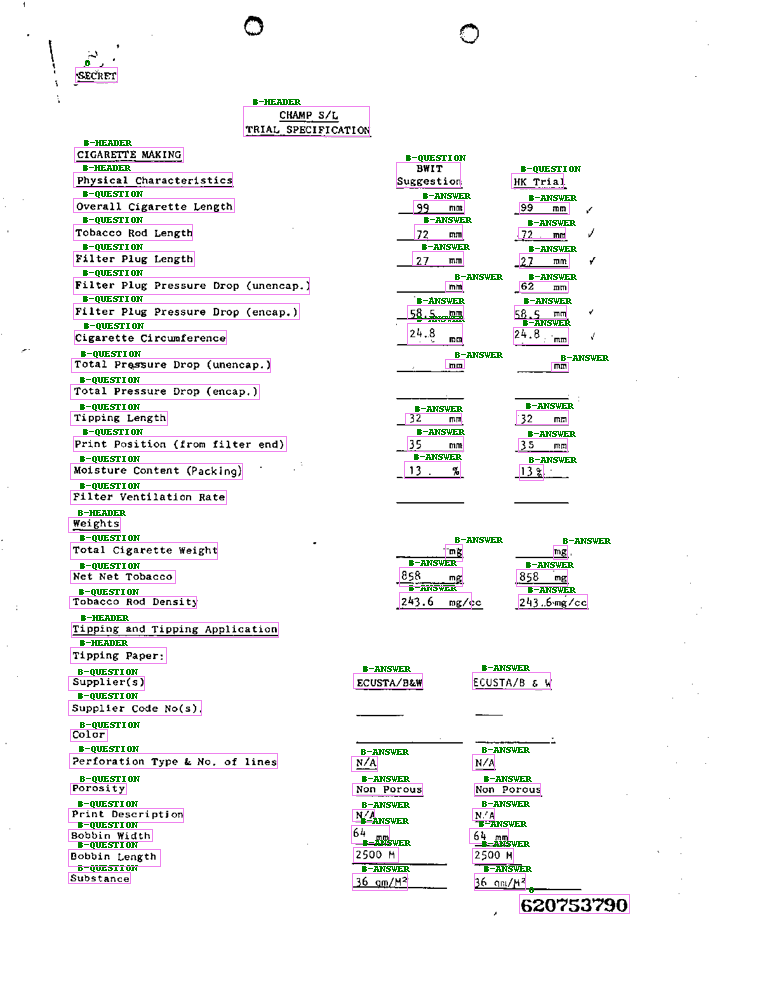

In [5]:
sample = dataset["train"][10]
annotated_img = plot_visualization(sample)
annotated_img

## Step 2 - Dataset Preperation

In [6]:
#---------AutoModel---------to check out inner working

In [7]:
class LayoutLMV3ForTokenClassification(nn.Module):
    
    def __init__(self, num_classes : int = 7):    ## 7 -> 0 to 6 classes
        super().__init__()
        
        self.model = AutoModel.from_pretrained("microsoft/layoutlmv3-base")
        hidden_dim = self.model.config.hidden_size    ## 768
        self.cls_layer = nn.Sequential(nn.Linear(in_features = hidden_dim,
                                                out_features = hidden_dim),
                                      nn.ReLU(), nn.Linear(in_features = hidden_dim, out_features = num_classes))
        
    def forward(self, batch):
        output = self.model(input_ids=batch["input_ids"],
                                bbox=batch["bbox"],
                                attention_mask=batch["attention_mask"],
                                pixel_values=batch["pixel_values"]).last_hidden_state[:, :512, :]   ## The output is [none, 709, 768], 
                                                                                                    ## not sure how does that come, so I took the first 
                                                                                                    ## 512 tokens
        
        output = self.cls_layer(output)
        
        return {"logits" : output}

In [8]:
#---------------defining the data features----------

In [9]:
column_names = dataset["train"].column_names
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

In [10]:
#------------preparing the data as per the LayoutLMv3 format-----------

In [11]:
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base",apply_ocr=False)
def prepare_dataset(sample):
    
    if isinstance(sample, dict):
        img = sample["image"]
        tokens = sample["tokens"]
        bbox = sample["bboxes"]
        ner_tags = sample["ner_tags"]
        
        encoding = processor(images = img, text = tokens, boxes = bbox, word_labels = ner_tags, truncation=True, padding="max_length")
    
    elif isinstance(sample, datasets.arrow_dataset.Batch):
        img = sample["image"]
        tokens = sample["tokens"]
        bbox = sample["bboxes"]
        ner_tags = sample["ner_tags"]
        
        encoding = processor(images = img, text = tokens, boxes = bbox, word_labels = ner_tags, truncation=True, padding="max_length")
        
    else:
        img = [item["image"] for item in sample]
        tokens = [item["tokens"] for item in sample]
        bbox = [item["bboxes"] for item in sample]
        ner_tags = [item["ner_tags"] for item in sample]
        
        encoding = processor(images = img, text = tokens, boxes = bbox, word_labels = ner_tags, truncation=True, padding="max_length")
        
    return encoding

In [12]:
#------------Extract all the information from a given image---------------

In [13]:
def prepare_dataset(sample):
    img = [item["image"] for item in sample] if isinstance(sample, list) else sample["image"]
    tokens = [item["tokens"] for item in sample] if isinstance(sample, list) else sample["tokens"]
    bbox = [item["bboxes"] for item in sample] if isinstance(sample, list) else sample["bboxes"]
    ner_tags = [item["ner_tags"] for item in sample] if isinstance(sample, list) else sample["ner_tags"]
    encoding = processor(images=img, text=tokens, boxes=bbox, word_labels=ner_tags, truncation=True, padding="max_length")
    return encoding

In [14]:
#-------Mapping the data using the above functions-------------

In [15]:
train_dataset = dataset["train"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

eval_dataset = dataset["test"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Loading cached processed dataset at C:\Users\15148\.cache\huggingface\datasets\nielsr___funsd-layoutlmv3\funsd\1.0.0\0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9\cache-db125ffecee29201.arrow


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [16]:
#-------prepared data set----------

In [17]:
train_dataset.set_format(type='torch', columns=['pixel_values', 'input_ids', 'attention_mask','bbox', 'labels'])
eval_dataset.set_format(type='torch', columns=['pixel_values', 'input_ids', 'attention_mask','bbox', 'labels'])

## Step 3 - Model Training

In [18]:
#-----------training and logging--------------

In [19]:
class DataModule(pl.LightningDataModule):

  def __init__(self, batch_size:int = 4):
    super(DataModule, self).__init__()
    self.batch_size = batch_size

  def train_dataloader(self):
    return DataLoader(train_dataset, batch_size = self.batch_size,
                      shuffle = True)
    
  def val_dataloader(self):
    return DataLoader(eval_dataset, batch_size = self.batch_size,
                      shuffle = False)

In [20]:
#---------------converts prediction and references tensors to numpy array--------------

In [21]:

def get_labels(predictions, references):
    if predictions.device.type == "cpu":
        y_pred = predictions.detach().clone().numpy()
        y_true = references.detach().clone().numpy()

    else:
        y_pred = predictions.detach().cpu().clone().numpy()
        y_true = references.detach().cpu().clone().numpy()
        
    true_predictions = [
        [labels[p] for (p, l) in zip(pred, gold_label) if l != -100]
        for pred, gold_label in zip(y_pred, y_true)
    ]
    true_labels = [
        [labels[l] for (p, l) in zip(pred, gold_label) if l != -100]
        for pred, gold_label in zip(y_pred, y_true)
    ]
    return true_predictions, true_labels

In [22]:
#-----------------training model using lightning module-----------------

In [23]:
class PLModel(pl.LightningModule):

    def __init__(self, lr = 5e-5):

        super(PLModel, self).__init__()
        self.save_hyperparameters()
    
        self.model = LayoutLMV3ForTokenClassification()

        self.train_metric = evaluate.load("seqeval")
        self.val_metric = evaluate.load("seqeval")

        self.lr = lr
  
    def forward(self, batch):
        return self.model(batch)

    def configure_optimizers(self):
        return AdamW(self.model.parameters(), lr = self.lr)

    def training_step(self, batch, batch_idx):

        outputs = self.forward(batch)

        predictions = outputs['logits'].argmax(-1)
        true_predictions, true_labels = get_labels(predictions, batch["labels"])
        self.train_metric.add_batch(references=true_labels, predictions=true_predictions)

        results = self.train_metric.compute()
        loss = F.cross_entropy(outputs['logits'].view(-1, 7), batch["labels"].view(-1))
    
        self.log("train_loss", loss.item(), prog_bar = True)
        self.log("train_overall_fl", results["overall_f1"], prog_bar = True)
        self.log("train_overall_recall", results["overall_recall"], prog_bar = True)
        self.log("train_overall_precision", results["overall_precision"], prog_bar = True)

        return loss

    def validation_step(self, batch, batch_idx):

        outputs = self.forward(batch)
        predictions = outputs['logits'].argmax(-1)
        true_predictions, true_labels = get_labels(predictions, batch["labels"])
        self.val_metric.add_batch(references=true_labels, predictions=true_predictions)

        results = self.val_metric.compute()
        loss = F.cross_entropy(outputs['logits'].view(-1, 7), batch["labels"].view(-1))
    
        self.log("val_loss", loss.item(), prog_bar = True)
        self.log("val_overall_fl", results["overall_f1"], prog_bar = True)
        self.log("val_overall_recall", results["overall_recall"], prog_bar = True)
        self.log("val_overall_precision", results["overall_precision"], prog_bar = True)
    
        return loss

In [24]:
def main():
    
    checkpoint_callback = ModelCheckpoint(
        dirpath="./layoutlmv3/models", monitor="val_loss", mode="min", filename = 'layoutlmv3_best_ckpt'
    )
    
    max_epochs = 10
    trainer = pl.Trainer(
        max_epochs = max_epochs,
        default_root_dir="./layoutlmv3/logs",
        accelerator="auto", 
        devices="auto",
        callbacks=[checkpoint_callback]
    )
    
    pl_model = PLModel()
    pl_dl = DataModule()
    
    trainer.fit(pl_model, pl_dl)

    return pl_model, pl_dl

In [29]:
if __name__ == "__main__":
    pl_model, pl_dl = main()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | LayoutLMV3ForTokenClassification | 125 M 
-----------------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
503.692   Total estimated model params size (MB)
C:\Users\m_areef\AppData\Roaming\Python\Python39\site-packages\lightning_fabric\loggers\csv_logs.py:188: UserWarning: Experiment logs directory layoutlmv3\logs\lightning_logs\version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Epoch 0: 100%|█| 38/38 [08:09<00:00, 12.87s/it, v_num=0, train_loss=0.945, train_overall_fl=0.557, train_overall_recall
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  92%|████████████████████████████████████████████████████▌    | 12/13 [01:06<00:05,  5.57s/it]
Epoch 0: 100%|█| 38/38 [09:18<00:00, 14.70s/it, v_num=0, train_loss=0.945, train_overall_fl=0.557, train_overall_recall
Epoch 1: 100%|█| 38/38 [08:13<00:00, 13.00s/it, v_num=0, train_loss=0.355, train_overall_fl=0.839, train_overall_recall
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  92%|████████████████████████████████████████████████████▌    | 12/13 [01:07<00:05,  5.66s/it]
Epoch 1: 100%|█| 38/38 [09:24<00:00, 14.86s/it, v_num=0, train_loss=0.355, train_overall_fl=0.839, train_overall_recall
Epoch 2: 100%|█| 38/38 [08:11<00:00, 12.93s/it, v_num=0, train_loss=0.242, train_overall_fl=0.884, train_overall_recall
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  92%|█████████████████████████████████████

Validation DataLoader 0:  92%|████████████████████████████████████████████████████▌    | 12/13 [01:05<00:05,  5.44s/it]
Epoch 8: 100%|█| 38/38 [09:07<00:00, 14.40s/it, v_num=0, train_loss=0.0224, train_overall_fl=1.000, train_overall_recal
Epoch 9: 100%|█| 38/38 [08:02<00:00, 12.69s/it, v_num=0, train_loss=0.021, train_overall_fl=1.000, train_overall_recall
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  92%|████████████████████████████████████████████████████▌    | 12/13 [01:05<00:05,  5.46s/it]
Epoch 9: 100%|█| 38/38 [09:10<00:00, 14.48s/it, v_num=0, train_loss=0.021, train_overall_fl=1.000, train_overall_recall
Epoch 9: 100%|█| 38/38 [09:10<00:00, 14.48s/it, v_num=0, train_loss=0.021, train_overall_fl=1.000, train_overall_recall

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 38/38 [09:10<00:00, 14.48s/it, v_num=0, train_loss=0.021, train_overall_fl=1.000, train_overall_recall


main()

## Step : 4 Evaluation

In [25]:
#--------------------load model from check point-------------------

In [26]:
model_path = os.path.join('./layoutlmv3/models', os.listdir('./layoutlmv3/models')[0])
pl_model = PLModel()
checkpoint = torch.load(model_path)
pl_model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [27]:
#----------------generating metrics for eval dataset----------------

In [28]:
pl_dl = DataModule()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eval_metric = evaluate.load("seqeval")
pl_model.eval();

model = pl_model.model.to(device)

for idx, batch in enumerate(tqdm(pl_dl.val_dataloader())):
    # move batch to device
    batch = {k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        outputs = model(batch)

    predictions = outputs['logits'].argmax(-1)
    true_predictions, true_labels = get_labels(predictions, batch["labels"])
    eval_metric.add_batch(references=true_labels, predictions=true_predictions)

  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\15148\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [29]:
results = eval_metric.compute()

In [30]:
for key in ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']:
    print_statement = '{0: <30}'.format(str(key) + " has value:")
    print(print_statement, results[key])

overall_precision has value:   0.8421781264420858
overall_recall has value:      0.9066070541480378
overall_f1 has value:          0.8732057416267942
overall_accuracy has value:    0.8345417805776774
